In [0]:
import torch
!pip install pyro-ppl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pyro.distributions as dist
import pyro
from torch.autograd import Variable
from pyro.infer.autoguide import AutoDiagonalNormal, AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, TracePredictive, EmpiricalMarginal
from torch.distributions import constraints
from pyro import poutine

Mounted at /gdrive
/gdrive
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks
     time  sunspot.year
0  1700.5           8.3
1  1701.5          18.3
2  1702.5          26.7
3  1703.5          38.3
4  1704.5          60.0


(array([16., 25., 25., 21., 10., 16., 14.,  8., 16., 13.,  9., 16.,  8.,
         7., 10., 14.,  9.,  6.,  7.,  8.,  7.,  6.,  5.,  1.,  5.,  6.,
         2.,  5.,  5.,  3.,  3.,  3.,  4.,  2.,  1.,  0.,  0.,  0.,  2.,
         1.]),
 array([  0.    ,   6.7325,  13.465 ,  20.1975,  26.93  ,  33.6625,
         40.395 ,  47.1275,  53.86  ,  60.5925,  67.325 ,  74.0575,
         80.79  ,  87.5225,  94.255 , 100.9875, 107.72  , 114.4525,
        121.185 , 127.9175, 134.65  , 141.3825, 148.115 , 154.8475,
        161.58  , 168.3125, 175.045 , 181.7775, 188.51  , 195.2425,
        201.975 , 208.7075, 215.44  , 222.1725, 228.905 , 235.6375,
        242.37  , 249.1025, 255.835 , 262.5675, 269.3   ]),
 <a list of 40 Patch objects>)

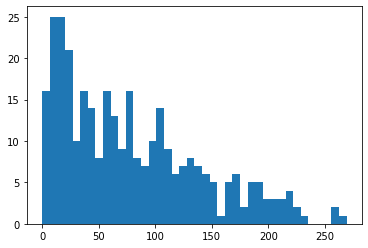

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd My\ Drive
%cd Colab\ Notebooks

df = pd.read_csv('sunspot.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
print (df.head())

plt.hist(df['sunspot.year'].values, bins=40)

In [0]:
import time

N = df.shape[0]

data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32)
def crp_model(data):
    alpha0 = pyro.sample('alpha', dist.Gamma(2, 4))
    # alpha0 = 2.
    cluster_rates = {}  # sample this lazily
    crp_counts = []  # build this incrementally
    for i in range(len(data)):
        # sample from a CRP
        weights = torch.tensor(crp_counts + [alpha0], dtype=torch.float32) 
        weights /= weights.sum()
        crp_weights = pyro.param("weights_{}".format(i), Variable(weights), constraint=constraints.positive)
        # print (crp_weights)

        zi = pyro.sample("z_{}".format(i), dist.Categorical(crp_weights))
        zi = zi.item() 

        if zi >= len(crp_counts):
            crp_counts.append(1)  # sit at a new table
        else:
            crp_counts[zi] += 1  # sit at an existing table


        # lazily sample cluster mean
        if zi not in cluster_rates.keys():
            cluster_rates[zi] = pyro.sample("lambda_{}".format(zi), dist.Uniform(0, 200))
        lambda_i = cluster_rates[zi]
        pyro.sample("obs_{}".format(i), dist.Poisson(lambda_i), obs=data[i])

# guide = AutoDiagonalNormal(crp_model)
guide = AutoDelta(poutine.block(crp_model, hide=['z_{}'.format(i) for i in range(len(data))]))
optim = Adam({"lr": 0.05})
svi = SVI(crp_model, guide, optim, loss=TraceEnum_ELBO(), num_samples=1000)

def train(num_iterations):
    pyro.clear_param_store()
    for j in range(num_iterations):
        loss = svi.step(data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train(1000)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))



[iteration 0001] loss: 29.1756
[iteration 0501] loss: 27.5145
weights_0 tensor([1.], grad_fn=<AddBackward0>)
weights_1 tensor([2.7198, 0.0757], grad_fn=<AddBackward0>)
weights_2 tensor([0.2665, 0.5278], grad_fn=<AddBackward0>)
weights_3 tensor([3.8994, 0.0270], grad_fn=<AddBackward0>)
weights_4 tensor([4.3224, 0.0194], grad_fn=<AddBackward0>)
weights_5 tensor([1.3194e+01, 5.2843e-03], grad_fn=<AddBackward0>)
weights_6 tensor([3.1031e+01, 1.9202e-03], grad_fn=<AddBackward0>)
weights_7 tensor([1.0178, 0.0511], grad_fn=<AddBackward0>)
weights_8 tensor([0.0498, 0.9264], grad_fn=<AddBackward0>)
weights_9 tensor([3.1468e+01, 1.3176e-03], grad_fn=<AddBackward0>)
weights_10 tensor([3.1558e+01, 1.1928e-03], grad_fn=<AddBackward0>)
weights_11 tensor([1.1065, 0.0312], grad_fn=<AddBackward0>)
weights_12 tensor([4.5458, 0.0070], grad_fn=<AddBackward0>)
weights_13 tensor([3.1746e+01, 9.2885e-04], grad_fn=<AddBackward0>)
weights_14 tensor([3.4497, 0.0080], grad_fn=<AddBackward0>)
weights_15 tensor([3

In [0]:
  # zi = pyro.sample("z", dist.Categorical(torch.Tensor([1])))
  # print (zi.item())





ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-510bd1c62fef>", line 12, in <module>
    Y = mop(X)
  File "<ipython-input-10-510bd1c62fef>", line 9, in mop
    return sum( [weights[i] * poisson.pmf(X, rate[i]) for i in range(10)] )
  File "<ipython-input-10-510bd1c62fef>", line 9, in <listcomp>
    return sum( [weights[i] * poisson.pmf(X, rate[i]) for i in range(10)] )
NameError: name 'rate' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent

NameError: ignored

[1.5012006e-01 1.3002673e-01 8.6913568e-01 5.8970086e-02 8.6771660e-03
 3.3982229e-05 1.6991236e-05 8.4957028e-06 6.0944916e-03 1.6991236e-05
 4.5757077e-04]


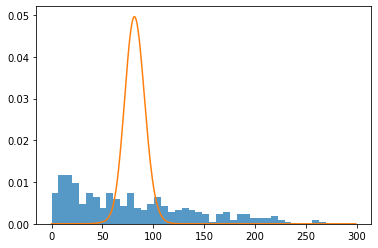

In [0]:
print(pyro.get_param_store())

from scipy.stats import poisson

X = np.arange(0, 300)

print (pyro.param('weights_318').detach().numpy())
# print ([pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(10)])

def mop(X):
  weights = pyro.param('weights_318').detach().numpy()
  rates = [pyro.param('auto_lambda_{}'.format(i)).detach().item() for i in range(10)]
  return sum( [weights[i] * poisson.pmf(X, rates[i]) for i in range(10)] )


Y = mop(X)
# print(Y)
plt.hist(data, bins=40, density=True, lw=0, alpha=0.75);
plt.plot(X, Y)
plt.show()
